# Simulation of simple grammar in working memory

### Set-up

In [2]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)


################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 20 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 0.5 # factor dampening connectivity amongst role neurons.

epsilon_cc = 6 # the ceiling of c-c connections when without long-term encoding, while taking into account of negative bias k. 
k_cc = 5 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 3 # the ceiling of c-f connections when without long-term encoding, while taking into account of negative bias k. 
k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 5.6 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -0.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 5.7 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

# seed that can be changed when running repeats to give rise to average recall accuracy.
# also note that seed will not have an effect on recall unless noise is added to the network.
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

## Simulation 1: Recall in a case of simplest possible grammar (no branching)

In simulation 1, we demonstrate that our syntactic working memory model is able to recall simple sentences. Then we demonstrate sentence superiority with the introduction of noise to the model.

In [3]:
LT_wc_knowledge = [[0,0],[1,1],[2,2],[3,3],[4,4],[5,5]] # word to role connections with long-term encoding
LT_cc_knowledge = [[0,1,2,3,4,5]] # sequence of role to role connections with long-term encoding
unified_noise = 0.5 # noise level if noise is present
cc_noise = True # any noise amongst role neurons
wc_noise = True # any noise between role and word neurons

# building the sentence
# to simulate a shuffled word list, change the word order appended to the sentence as required
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(num_steps): sentence.append(cjn.in_in(word=5))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)



********************
Epoch = 1
Number of recorded time steps:  321
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase.

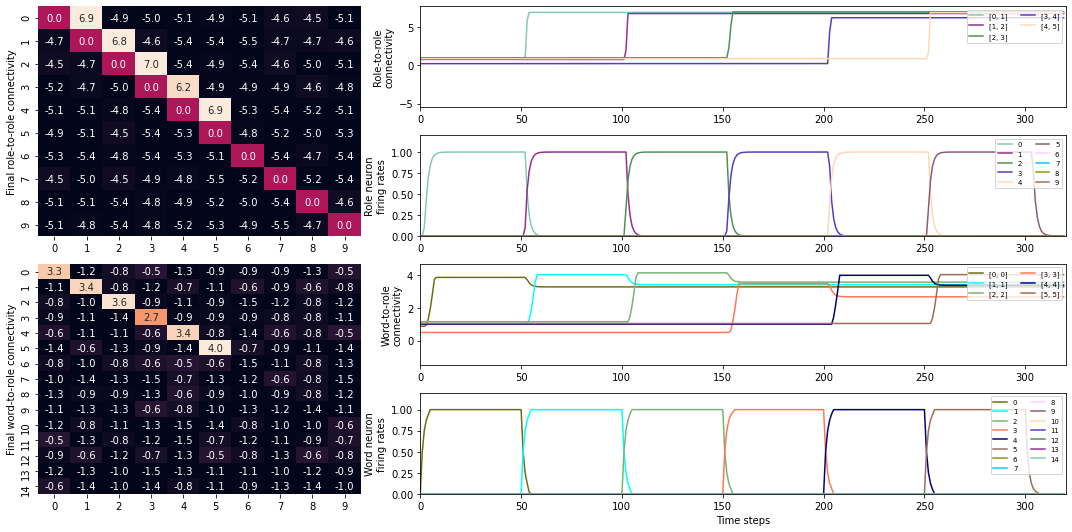

In [4]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall phase with visualisation

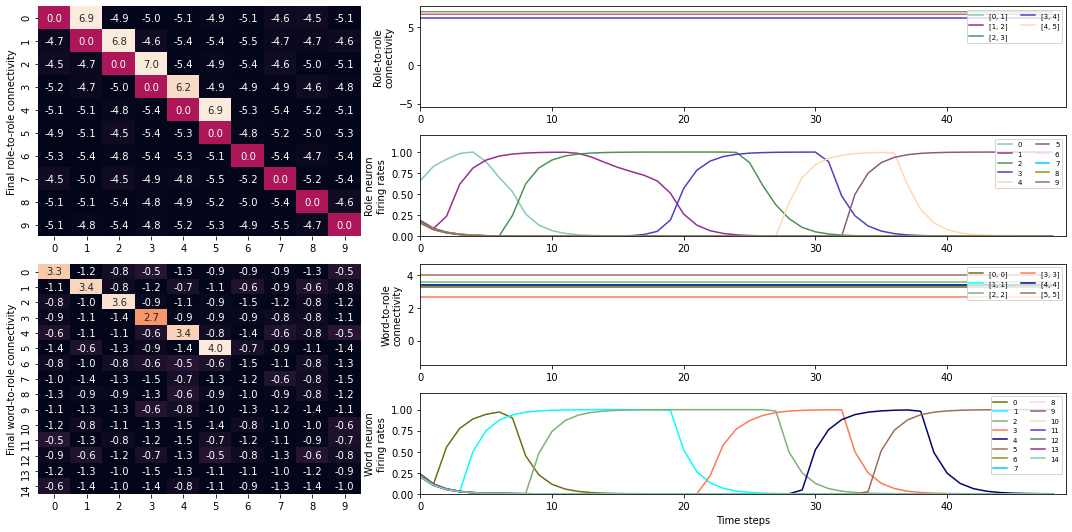

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0], [4.0], [5.0]]


In [5]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Simulation 2: Switching encoding between two sentences with the same syntax, where words compete for overlapping roles.

In simulation 2, we demonstrate that the network can recall even after switching between sentences that have the same syntax but with words that have overlapping roles. For example, 'my dogs like cats' vs. 'my cats like dogs'.

In [6]:
LT_wc_knowledge = [[0,0],[1,1],[2,2],[3,1],[1,3],[3,3]] # long-term word to role encoding
LT_cc_knowledge = [[0,1,2,3]] # long-term role to role encoding in sequential order
unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  221
********************


### Visualisation of encoding

We can visualise the learning that occurred during the first encoding phase. <br>
Note in the word-to-role heatmap, there are long-term encodings that did not receive rapid synaptic plasticities (word 1 to role 3, and word 3 to role 1). This is unlike simulation 1 where all long-term encodings were used.

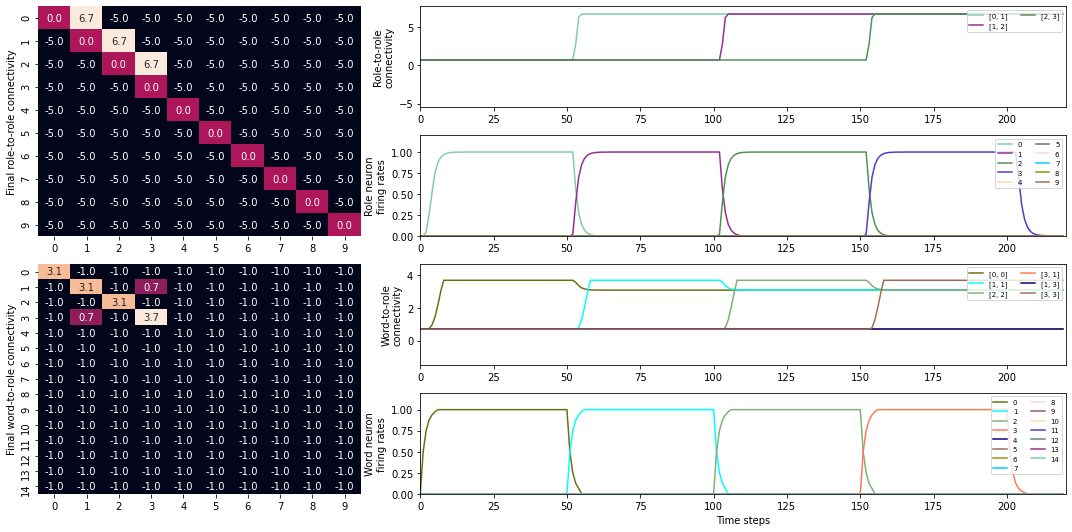

In [7]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of first sentence

We test that the network is able to recall the above encoded sentence.

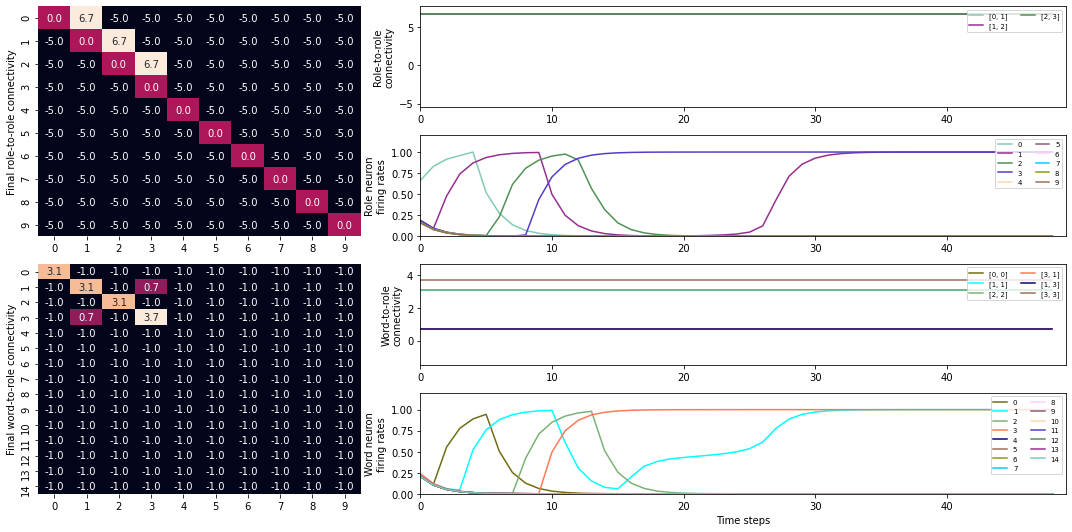

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0]]


In [8]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Encoding the next sentence

Next we encode the second sentence with the same syntax but with words in different roles. <br>
Note that we are reusing the network from above and **not** re-initialising a another network.

In [9]:
# building the second sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(tail): sentence.append(cjn.in_in())

# encoding the second sentence by re-using the above network
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  221
********************


### Visualisation of encoding of the second sentence

We can visualise the learning that occurred during the second encoding phase. <br>
Notice the change in rapid synaptic plasticities between word to role neurons.

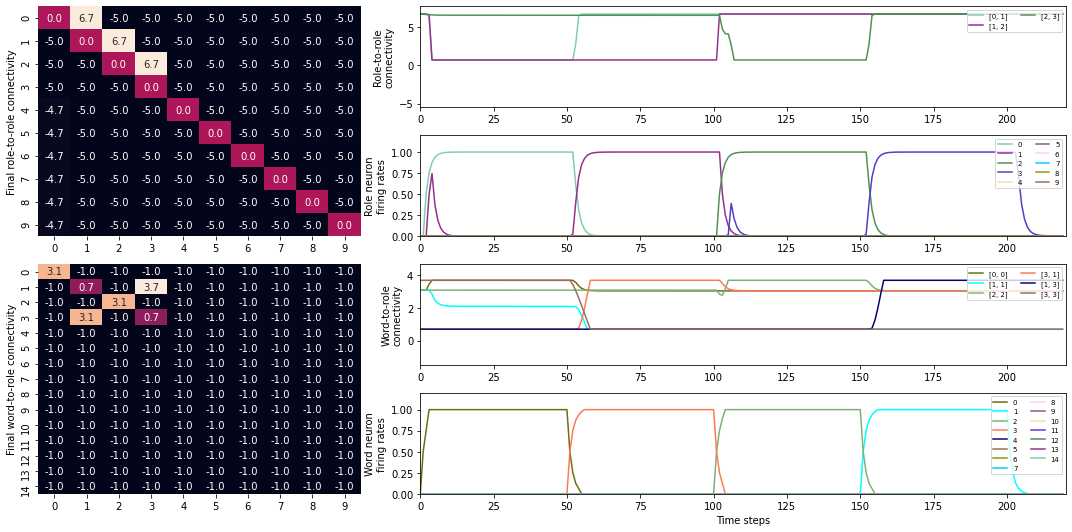

In [10]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of second sentence

Finally, we show that the network successfully recalls the second encoded sentence.

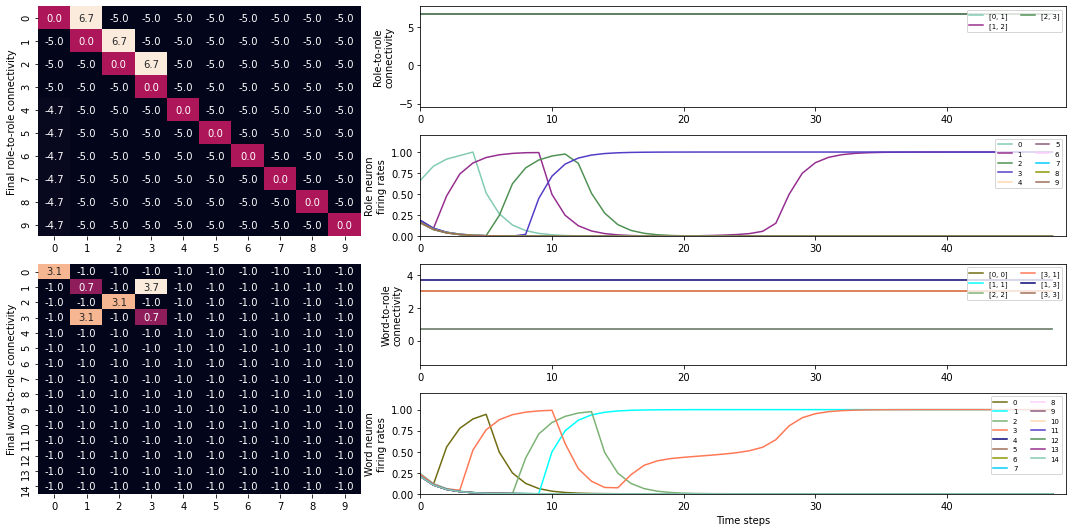

The final recall output is: 
[[0.0], [3.0], [2.0], [1.0]]


In [11]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Simulation 3: Switching between two sentences with overlapping syntactic structures

In simulation 3, we demonstrate the network is able to switch encoding between two syntactive pathways, one with and one without an adjective. <br>
For example, 'that dog is mine' vs. 'that brown dog is mine'.

In [12]:
LT_wc_knowledge = [[0,0],[1,1],[2,2],[3,3],[4,4]] # long-term word to role encoding
LT_cc_knowledge = [[0,2,3,4],[0,1,2,3,4]] # long-term role to role encoding in sequential order
unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  271
********************


### Visualisation of encoding of first sentence

We have first encoded a sentence with an adjective. You may do the reverse by encoding a sentence without an adjective first. <br>
We will now visualise the learning that occurred during the first encoding phase. <br>
Note in the role-to-role heatmap, there is a long-term encoding that did not receive rapid synaptic plasticities (role 0 to role 2).

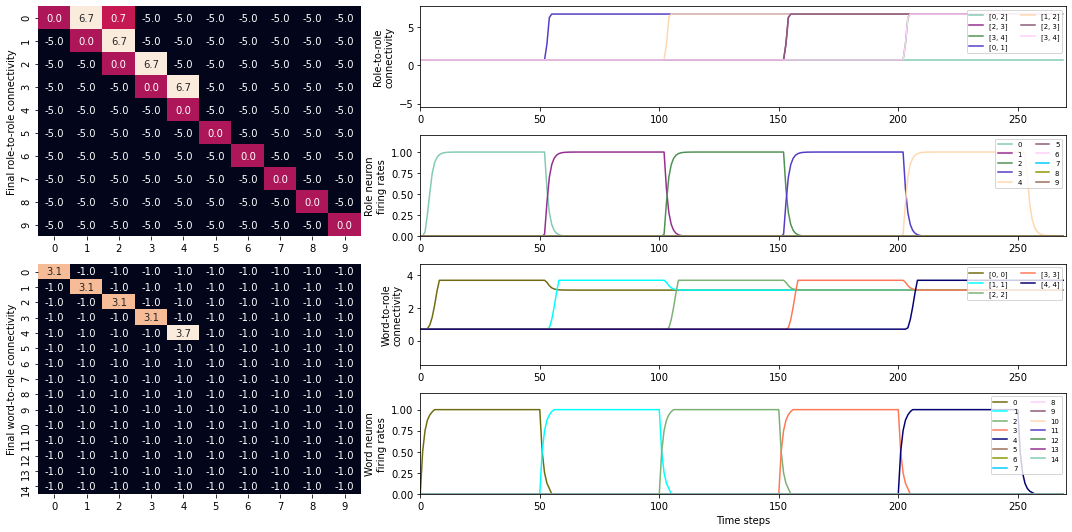

In [13]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of first sentence

Like before, we test that the network is able to recall the above encoded sentence.

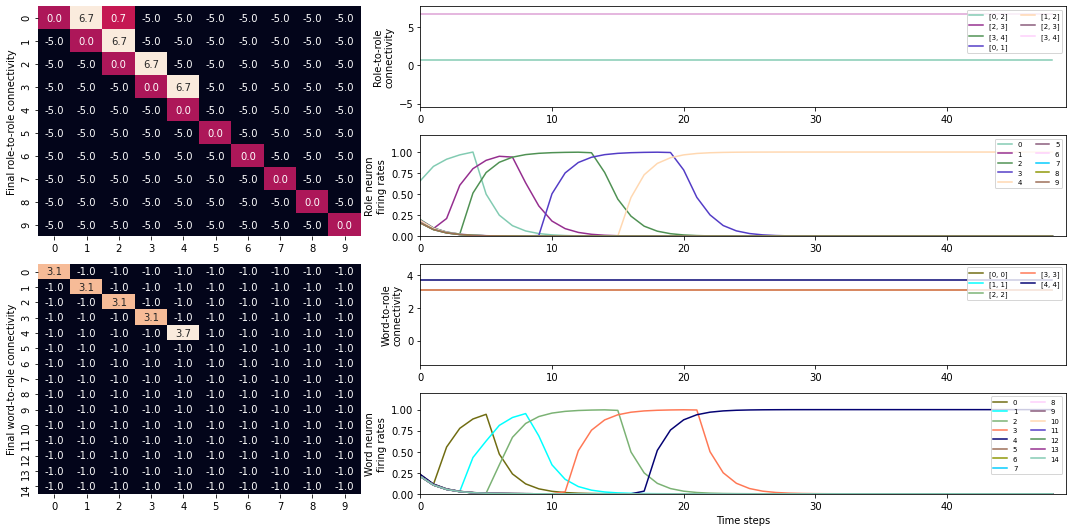

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0], [4.0]]


In [14]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Encoding the next sentence

Next we encode the second sentence which has no adjective. <br>
Like in simulation 2, we are reusing the network from above and **not** re-initialising a another network.

In [15]:
# building the second sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(tail): sentence.append(cjn.in_in())

# encoding the second sentence by re-using the above network
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  221
********************


### Visualisation of encoding of the second sentence

We then visualise the learning that occurred during the second encoding phase. <br>
Notice the change in rapid synaptic plasticities between role to role neurons.

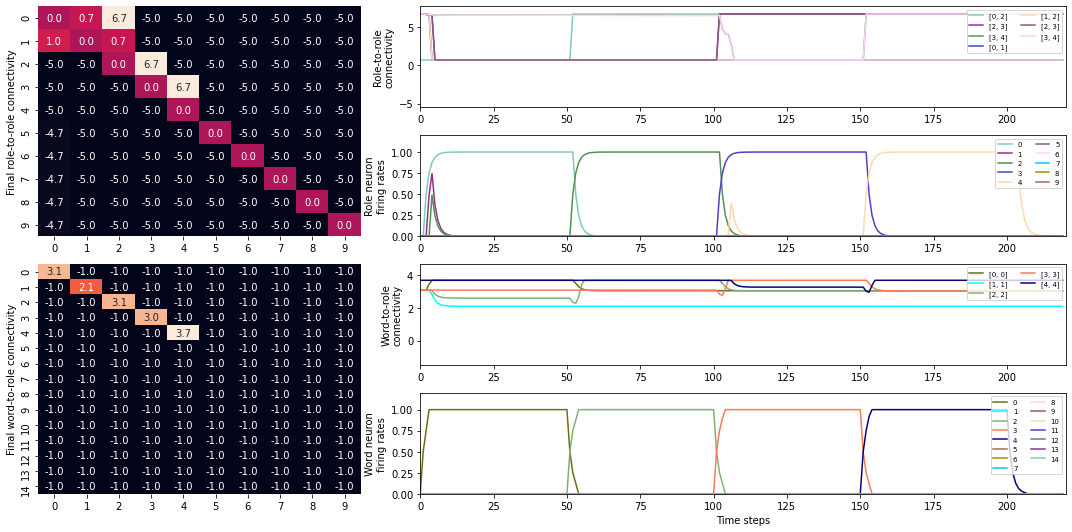

In [16]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)

### Recall of second sentence

Finally, we show that the network successfully recalls the second encoded sentence.

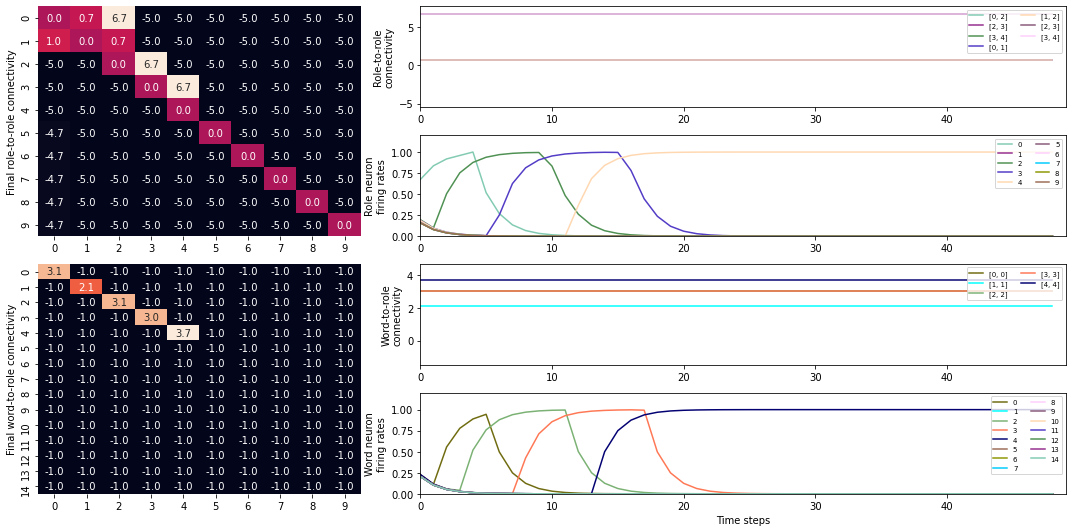

The final recall output is: 
[[0.0], [2.0], [3.0], [4.0]]


In [17]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Simulation 4: Switching between all four sentences

In simulation 4, we demonstrate the network is able to switch encoding between all 4 previously encountered sentences. <br>

In [40]:
LT_wc_knowledge = [[0,0],[1,1],[2,2],[2,4],[3,3],[4,4],[4,2]] # long-term word to role encoding
LT_cc_knowledge = [[0,2,3,4],[0,1,2,3,4]] # long-term role to role encoding in sequential order
unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  221
********************


### Visualisation of encoding of the first sentence

We first visualise the learning that occurs during the encoding of a sentence without adjective. <br>

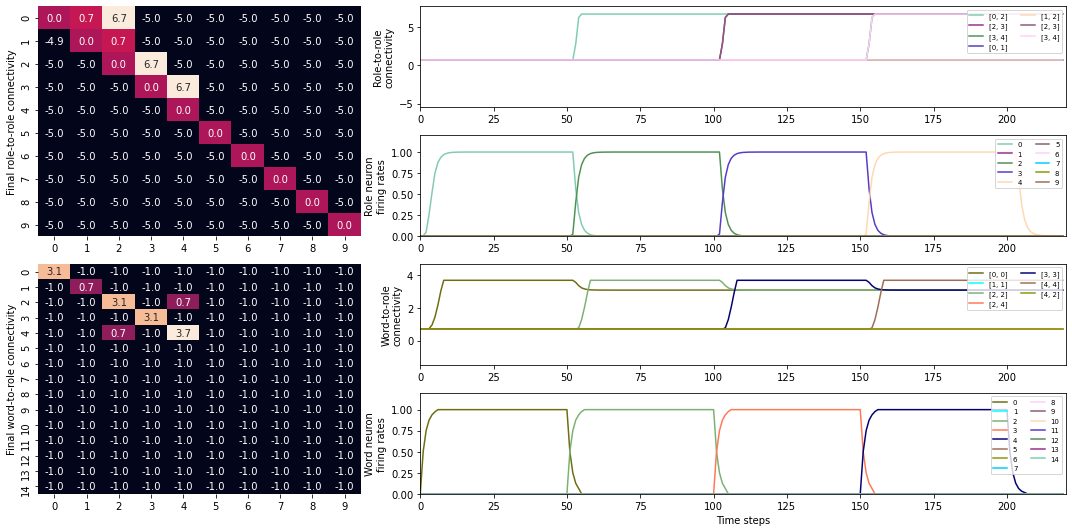

In [41]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)

### Recall of first sentence

We show that the network successfully recalls this first sentence.

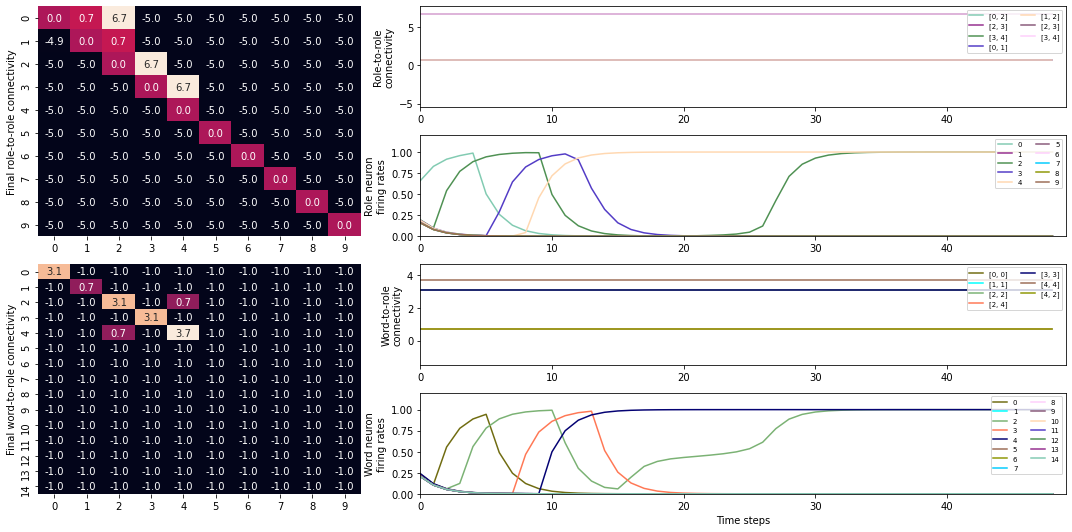

The final recall output is: 
[[0.0], [2.0], [3.0], [4.0]]


In [42]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Encoding the second sentence with an adjective

Next we encode the second sentence which has an adjective. <br>

In [44]:
# building the second sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(tail): sentence.append(cjn.in_in())

# encoding the second sentence by re-using the above network
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  271
********************


### Visualisation of encoding of the second sentence

We visualise the learning that occurs during the encoding of a sentence with adjective. <br>
Note that unlike in simulation 3, there are multiple additional long-term encoding branchings between word and role neurons.

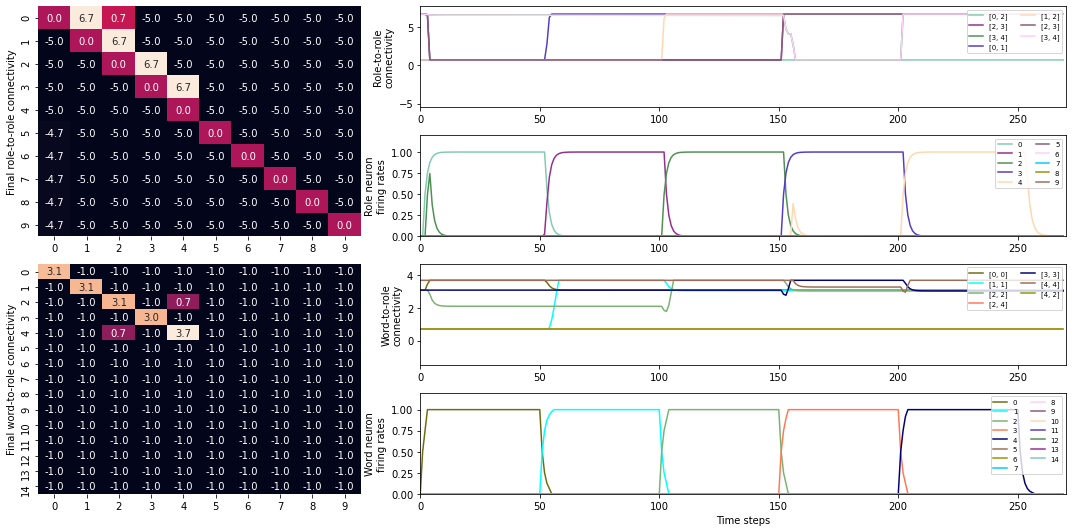

In [45]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)

### Recall of second sentence

We show that the network successfully recalls this second sentence.

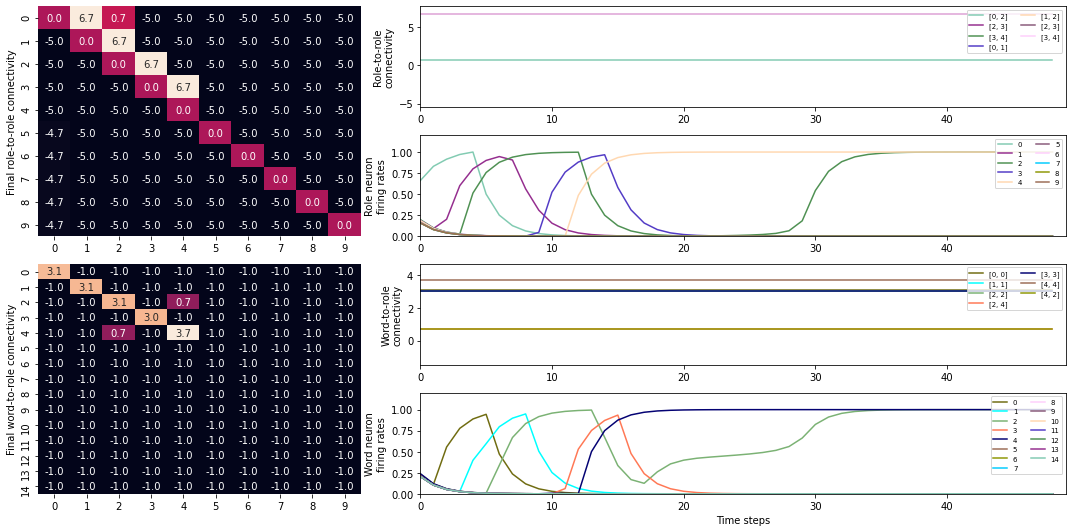

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0], [4.0]]


In [46]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Encoding a third sentence with switching between roles of the words

We further demonstrate that the motif in simulation 2 can co-exist with the motif seen in simulation 3. <br>

In [48]:
# building the second sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(tail): sentence.append(cjn.in_in())

# encoding the second sentence by re-using the above network
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  271
********************


### Visualisation of encoding of the third sentence

We visualise the encoding of this third sentence.

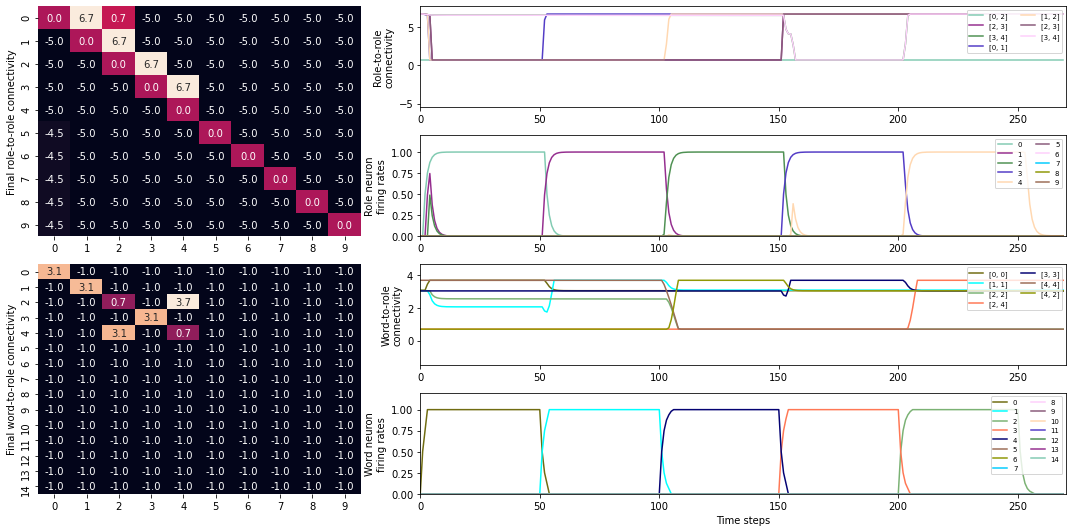

In [49]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)

### Recall of third sentence

We show that the network successfully recalls this third sentence.

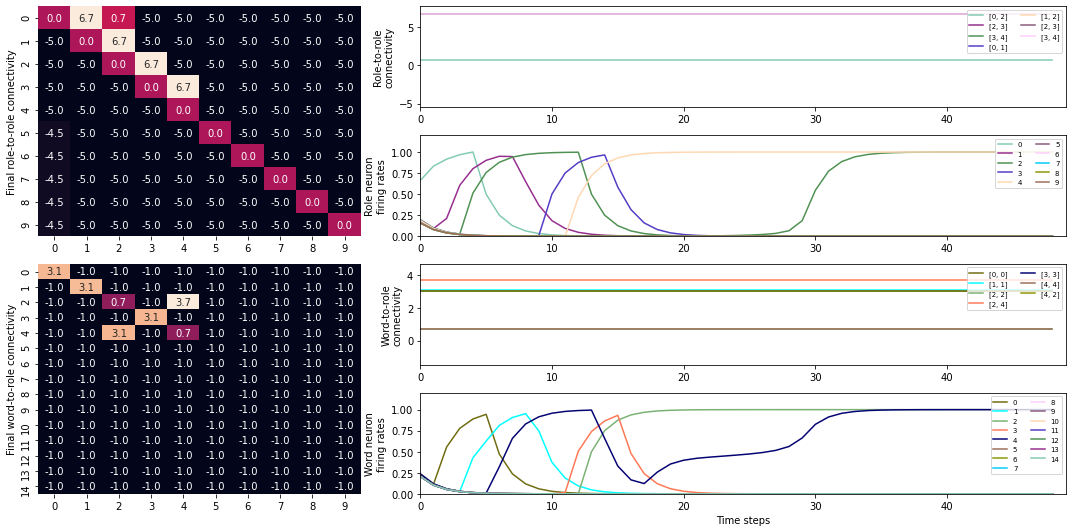

The final recall output is: 
[[0.0], [1.0], [4.0], [3.0], [2.0]]


In [50]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Encoding a fourth sentence with simultaneous changes in both motifs

In this final step, we demonstrate that the model is able to handle switching of both motifs simultaneously. <br>

In [52]:
# building the second sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4))
for n in range(tail): sentence.append(cjn.in_in())

# encoding the second sentence by re-using the above network
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  221
********************


### Visualisation of encoding

The model switches from the third sentence which has an adjective to the first sentence which has no adjective, and simultaneously switching the roles of word 2 and 4.

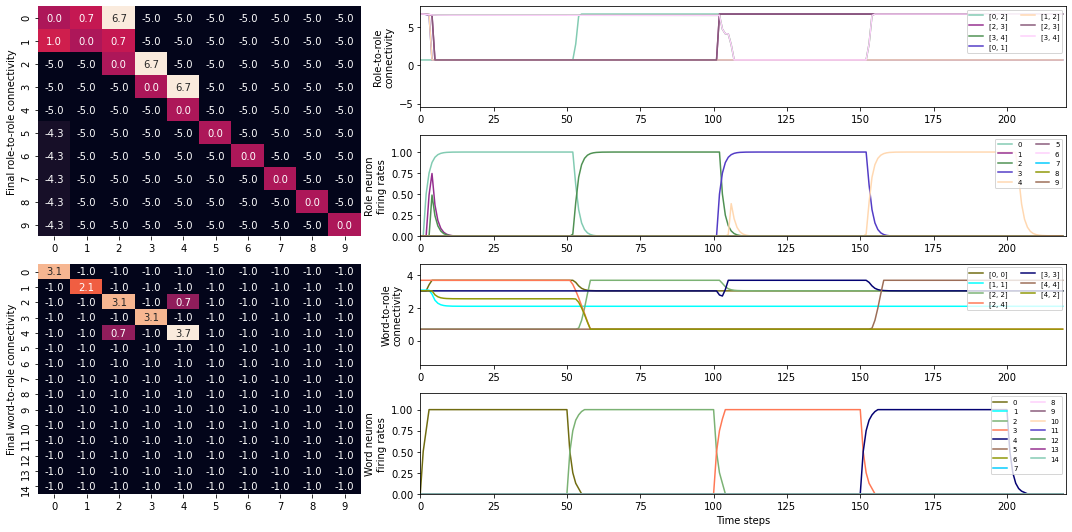

In [53]:
cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)

### Final recall

We show that the network successfully recalls the first sentence.

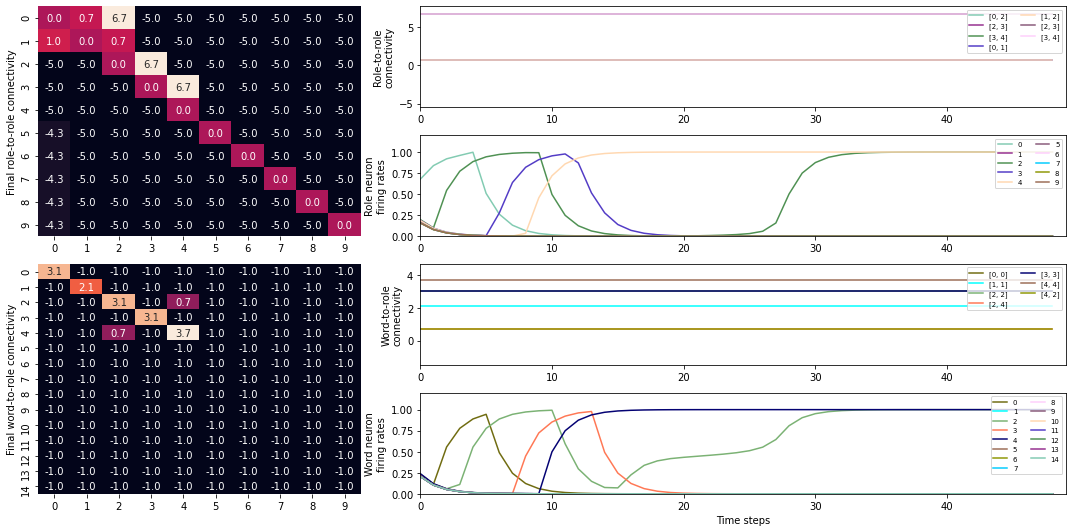

The final recall output is: 
[[0.0], [2.0], [3.0], [4.0]]


In [54]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 50 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))